In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from PIL import Image
from scipy.stats import norm
import glob
import tensorflow as tf
import sys
sys.path.append('..')
from utils import *
#from tensorflow.contrib import layers

### Load Data list names
Rather than load all the data into ram. We just load the names of all the images and annotations. Shuffle the names and partition them into train and test sets. Then we only load the images/annotations when neeed.

In [2]:
base_dir      = '../data/gray_80_80_annotated/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'

raw_train = load_data(train_path)
raw_test = load_data(test_path)

# Bin Steering Data
The steering and throttle annotations come in as numbers between 0 and 1023. So our network does not need to have 1024 output neurons we partition the data into bins.

ie:

if we had data consisting of numbers 0-9 :



`data = [1,4,5,0,9,8,5,4,3,2,5,6,7]`

and we binned in lost of 2 the our data would look like this:
```
# bins:  0   1   2   3   4
# nums: 01, 23, 45, 67, 89

binned = [0,2,2,0,4,4,2,2,1,1,2,3,3]
```

In [4]:
NUM_BINS = 8
train = bin_steering_annos(raw_train, NUM_BINS)
test = bin_steering_annos(raw_test, NUM_BINS)
for i,a in train[100:110]:
    print(a)

2.0
4.0
6.0
4.0
0.0
5.0
1.0
3.0
2.0
5.0


## Data Generator

This is what we're going to use to take care of loading our actual images and annotations as we need them. When initalized it shuffles the `data_names` then calling the `get_next_bacth` function returns a tuple of `(images, annotations)`. Calling the `still_has_data`function returns a boolean indicating wether or not all the data has been used up.

In [5]:
from data_generator import DataGenerator

In [6]:
my_data=DataGenerator(batch_size=10, 
                      data_set=train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)


Below we plot a histogram of the data we're going to use to train the model. Just to make sure there is not a crazy bias in the data.

*eg: if the video containing the data has the car parked for a few seconds at the beginning and end of a run you may get a large spike in the data around 'go strait'*

anno check: min: 0.0, max: 7.0, mean: 3.397530864197531


(array([ 436.,  785., 1577.,    0., 1749., 1239.,    0., 1081.,  658.,
         575.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

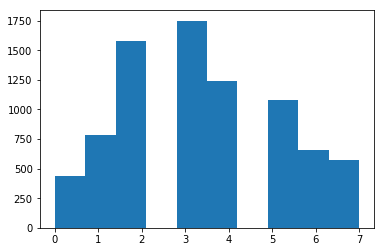

In [7]:
annos = my_data._all_annotations()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))
plt.hist(annos)

anno check: min: 1.0, max: 7.0, mean: 4.9


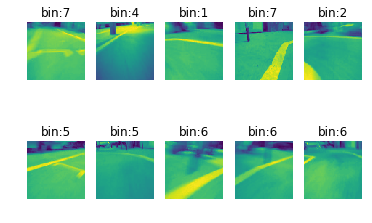

In [8]:
images, annos = my_data.get_next_batch()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))

for i, (im, an) in enumerate(zip(images[:10], annos[:10])):
    plot = i+1
    plt.subplot(2,5,plot)
#     print("shape: {}".format(np.shape(im[:,:,0])))
    plt.imshow(im[:,:,0])
    plt.axis('off')
    # Covert to +- 100% for hard left or hard right
    angle = an
    plt.title("bin:{}".format(int(angle)))


### Some hyperparams

In [9]:
# epochs           = 5
# input_shape      = (80,80,1)
# num_chans        = 1
# batch_size       = 50

# #input_dim        = np.prod(input_shape)  # flattened size of input_image
# intermediate_dim = 255
# intermediate_dim = 50
# out_dim          = 3
# learning_rate    = 0.001
# optimizer        = tf.train.AdamOptimizer(learning_rate=learning_rate)  

In [10]:
from show_graph import show_graph
from model import Model
car_brain = Model()
#show_graph(car_brain.GetGraph())
# show_graph(tf.get_default_graph().as_graph_def())

### Defining the model

In [13]:
train_gen=DataGenerator(batch_size=50, 
                      data_set=train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

test_gen=DataGenerator(batch_size=50, 
                      data_set=test,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

In [14]:
epochs = 10
batch_size = 50
learning_rate = 0.001
car_brain.Train(train_gen=train_gen,
               test_gen=test_gen,
               epochs=epochs)



  0%|          | 0/162 [00:00<?, ?it/s]

Epoch 1
Training


  0%|          | 0/41 [00:00<?, ?it/s]

Testing



100%|██████████| 41/41 [00:04<00:00,  9.13it/s]


Test Loss: 1.809, Test Acc: 0.817
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_1-step_161-loss_1.81.ckpt
Epoch 2
Training



  2%|▏         | 1/41 [00:00<00:04,  8.98it/s]

Testing



100%|██████████| 41/41 [00:04<00:00,  9.42it/s]


Test Loss: 1.720, Test Acc: 0.826
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_2-step_161-loss_1.72.ckpt
Epoch 3
Training



  2%|▏         | 1/41 [00:00<00:04,  9.14it/s]

Testing



100%|██████████| 41/41 [00:04<00:00,  9.20it/s]


Test Loss: 1.551, Test Acc: 0.842
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_3-step_161-loss_1.55.ckpt
Epoch 4
Training



  2%|▏         | 1/41 [00:00<00:04,  8.57it/s]

Testing



100%|██████████| 41/41 [00:04<00:00,  9.03it/s]


Test Loss: 1.369, Test Acc: 0.872
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_4-step_161-loss_1.37.ckpt
Epoch 5
Training



  2%|▏         | 1/41 [00:00<00:04,  9.03it/s]

Testing



100%|██████████| 41/41 [00:04<00:00,  8.87it/s]


Test Loss: 1.286, Test Acc: 0.885
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_5-step_161-loss_1.29.ckpt
Epoch 6
Training



  2%|▏         | 1/41 [00:00<00:07,  5.39it/s]

Testing



100%|██████████| 41/41 [00:04<00:00,  8.45it/s]


Test Loss: 1.174, Test Acc: 0.900
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_6-step_161-loss_1.17.ckpt
Epoch 7
Training



  0%|          | 0/41 [00:00<?, ?it/s]

Testing



100%|██████████| 41/41 [00:05<00:00,  7.68it/s]


Test Loss: 1.062, Test Acc: 0.908
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_7-step_161-loss_1.06.ckpt
Epoch 8
Training



  2%|▏         | 1/41 [00:00<00:05,  7.48it/s]

Testing



100%|██████████| 41/41 [00:05<00:00,  7.39it/s]


Test Loss: 0.979, Test Acc: 0.918
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_8-step_161-loss_0.979.ckpt
Epoch 9
Training



  2%|▏         | 1/41 [00:00<00:04,  8.43it/s]

Testing



100%|██████████| 41/41 [00:05<00:00,  7.65it/s]


Test Loss: 0.857, Test Acc: 0.931
--------------------------------------------------



  0%|          | 0/162 [00:00<?, ?it/s]

Model saved at ./ep_9-step_161-loss_0.857.ckpt
Epoch 10
Training



  2%|▏         | 1/41 [00:00<00:04,  8.76it/s]

Testing



100%|██████████| 41/41 [00:04<00:00,  8.38it/s]


Test Loss: 0.828, Test Acc: 0.936
--------------------------------------------------
Model saved at ./ep_10-step_161-loss_0.828.ckpt
Done, final best loss: 0.828


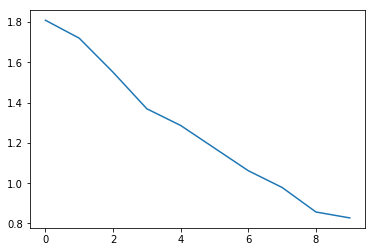

In [16]:
tr_loss, te_loss, te_acc = car_brain.TrainingResults()
plt.plot(te_loss)

### Perform Prediction on images using ONLY test data


In [23]:
test_gen = DataGenerator(batch_size=10, 
                      data_set=test[:100],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)
test_image, anno = test_gen.get_next_batch()
ckpt = "ep_10-step_161-loss_0.828.ckpt"
probs, preds = car_brain.Predict(test_image, ckpt)
pred_angles = car_brain.ExpectedBinToDeg(preds)

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


len:  10


/home/jp/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Prob')

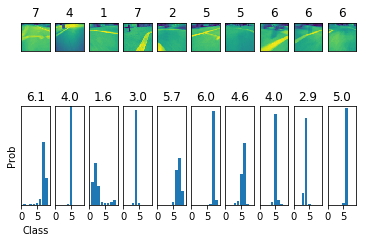

In [24]:
bins = list(range(1,NUM_BINS+1))
y_pos = np.arange(8)
print("len: ", len(annos))
for i, (im, an, prob, pred) in enumerate(zip(images, annos, probs, preds)):
    plot = i + 1
    plt.subplot(2,10,plot)
    plt.xticks([])    
    plt.yticks([])
    plt.title("{}".format(int(an)))
    plt.imshow(im[:,:,0])
    
    plot += 10
    plt.subplot(2,10,plot)
    plt.bar(bins, prob)
    plt.axis([0, 9, 0, 1.])
    plt.yticks([],[])
    plt.title("{:.2}".format(pred))
    
plt.subplot(2,10,11)
plt.xlabel("Class")
plt.ylabel("Prob")
#plt.yticks([0.,0.2, 0.4, 0.6, 0.8, 1.0])

In [25]:
all_data_sequential = load_data("../data/all_data_sequential.txt")
all_img_paths = [f"../data/gray_80_80_annotated/images/{ele[0]}.jpg" for ele in all_data_sequential]
# all_images    = load_images(all_img_paths)

In [30]:
all_gen = DataGenerator(batch_size=50, 
                      data_set=all_data_sequential,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS,
                      shuffle=False)
predictions = list()
ckpt = "ep_10-step_161-loss_0.828.ckpt"
pbar = tqdm(list(range(all_gen.steps_per_epoch)))
for step in pbar:
    test_image, anno = all_gen.get_next_batch()
    probs, preds = car_brain.Predict(test_image, ckpt)
    pred_angles = car_brain.ExpectedBinToDeg(preds)
    predictions.extend(preds)

  0%|          | 0/395 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  0%|          | 1/395 [00:00<01:45,  3.75it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  1%|          | 2/395 [00:00<01:45,  3.73it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  1%|          | 3/395 [00:00<01:47,  3.65it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  1%|          | 4/395 [00:01<01:47,  3.65it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  1%|▏         | 5/395 [00:01<01:49,  3.58it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  2%|▏         | 6/395 [00:01<01:53,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  2%|▏         | 7/395 [00:02<01:55,  3.37it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  2%|▏         | 8/395 [00:02<01:53,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  2%|▏         | 9/395 [00:02<01:53,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  3%|▎         | 10/395 [00:02<01:52,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  3%|▎         | 11/395 [00:03<01:51,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  3%|▎         | 12/395 [00:03<01:50,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  3%|▎         | 13/395 [00:03<01:51,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  4%|▎         | 14/395 [00:04<01:52,  3.38it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  4%|▍         | 15/395 [00:04<01:52,  3.38it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  4%|▍         | 16/395 [00:04<01:51,  3.39it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  4%|▍         | 17/395 [00:04<01:50,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  5%|▍         | 18/395 [00:05<01:50,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  5%|▍         | 19/395 [00:05<01:49,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  5%|▌         | 20/395 [00:05<01:49,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  5%|▌         | 21/395 [00:06<01:48,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  6%|▌         | 22/395 [00:06<01:48,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  6%|▌         | 23/395 [00:06<01:47,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  6%|▌         | 24/395 [00:06<01:47,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  6%|▋         | 25/395 [00:07<01:46,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  7%|▋         | 26/395 [00:07<01:46,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  7%|▋         | 27/395 [00:07<01:45,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  7%|▋         | 28/395 [00:08<01:45,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  7%|▋         | 29/395 [00:08<01:44,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  8%|▊         | 30/395 [00:08<01:44,  3.50it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  8%|▊         | 31/395 [00:08<01:43,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  8%|▊         | 32/395 [00:09<01:43,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  8%|▊         | 33/395 [00:09<01:42,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  9%|▊         | 34/395 [00:09<01:42,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  9%|▉         | 35/395 [00:09<01:42,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  9%|▉         | 36/395 [00:10<01:41,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


  9%|▉         | 37/395 [00:10<01:41,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 10%|▉         | 38/395 [00:10<01:41,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 10%|▉         | 39/395 [00:11<01:40,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 10%|█         | 40/395 [00:11<01:40,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 10%|█         | 41/395 [00:11<01:40,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 11%|█         | 42/395 [00:11<01:40,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 11%|█         | 43/395 [00:12<01:40,  3.50it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 11%|█         | 44/395 [00:12<01:40,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 11%|█▏        | 45/395 [00:12<01:40,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 12%|█▏        | 46/395 [00:13<01:40,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 12%|█▏        | 47/395 [00:13<01:40,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 12%|█▏        | 48/395 [00:13<01:40,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 12%|█▏        | 49/395 [00:14<01:40,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 13%|█▎        | 50/395 [00:14<01:40,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 13%|█▎        | 51/395 [00:14<01:40,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 13%|█▎        | 52/395 [00:15<01:40,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 13%|█▎        | 53/395 [00:15<01:40,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 14%|█▎        | 54/395 [00:15<01:39,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 14%|█▍        | 55/395 [00:16<01:39,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 14%|█▍        | 56/395 [00:16<01:38,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 14%|█▍        | 57/395 [00:16<01:38,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 15%|█▍        | 58/395 [00:16<01:38,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 15%|█▍        | 59/395 [00:17<01:37,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 15%|█▌        | 60/395 [00:17<01:37,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 15%|█▌        | 61/395 [00:17<01:37,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 16%|█▌        | 62/395 [00:18<01:37,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 16%|█▌        | 63/395 [00:18<01:37,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 16%|█▌        | 64/395 [00:18<01:37,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 16%|█▋        | 65/395 [00:19<01:37,  3.39it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 17%|█▋        | 66/395 [00:19<01:36,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 17%|█▋        | 67/395 [00:19<01:36,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 17%|█▋        | 68/395 [00:19<01:36,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 17%|█▋        | 69/395 [00:20<01:35,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 18%|█▊        | 70/395 [00:20<01:35,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 18%|█▊        | 71/395 [00:20<01:34,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 18%|█▊        | 72/395 [00:21<01:34,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 18%|█▊        | 73/395 [00:21<01:34,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 19%|█▊        | 74/395 [00:21<01:33,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 19%|█▉        | 75/395 [00:21<01:33,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 19%|█▉        | 76/395 [00:22<01:33,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 19%|█▉        | 77/395 [00:22<01:32,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 20%|█▉        | 78/395 [00:22<01:32,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 20%|██        | 79/395 [00:22<01:31,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 20%|██        | 80/395 [00:23<01:31,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 21%|██        | 81/395 [00:23<01:31,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 21%|██        | 82/395 [00:23<01:30,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 21%|██        | 83/395 [00:24<01:30,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 21%|██▏       | 84/395 [00:24<01:30,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 22%|██▏       | 85/395 [00:24<01:29,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 22%|██▏       | 86/395 [00:24<01:29,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 22%|██▏       | 87/395 [00:25<01:29,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 22%|██▏       | 88/395 [00:25<01:29,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 23%|██▎       | 89/395 [00:25<01:28,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 23%|██▎       | 90/395 [00:26<01:28,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 23%|██▎       | 91/395 [00:26<01:28,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 23%|██▎       | 92/395 [00:26<01:28,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 24%|██▎       | 93/395 [00:27<01:28,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 24%|██▍       | 94/395 [00:27<01:27,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 24%|██▍       | 95/395 [00:27<01:27,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 24%|██▍       | 96/395 [00:28<01:27,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 25%|██▍       | 97/395 [00:28<01:27,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 25%|██▍       | 98/395 [00:28<01:27,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 25%|██▌       | 99/395 [00:29<01:26,  3.40it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 25%|██▌       | 100/395 [00:29<01:26,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 26%|██▌       | 101/395 [00:29<01:26,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 26%|██▌       | 102/395 [00:29<01:25,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 26%|██▌       | 103/395 [00:30<01:25,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 26%|██▋       | 104/395 [00:30<01:25,  3.41it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 27%|██▋       | 105/395 [00:30<01:24,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 27%|██▋       | 106/395 [00:31<01:24,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 27%|██▋       | 107/395 [00:31<01:24,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 27%|██▋       | 108/395 [00:31<01:23,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 28%|██▊       | 109/395 [00:31<01:23,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 28%|██▊       | 110/395 [00:32<01:23,  3.42it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 28%|██▊       | 111/395 [00:32<01:22,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 28%|██▊       | 112/395 [00:32<01:22,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 29%|██▊       | 113/395 [00:32<01:22,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 29%|██▉       | 114/395 [00:33<01:21,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 29%|██▉       | 115/395 [00:33<01:21,  3.43it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 29%|██▉       | 116/395 [00:33<01:21,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 30%|██▉       | 117/395 [00:34<01:20,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 30%|██▉       | 118/395 [00:34<01:20,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 30%|███       | 119/395 [00:34<01:20,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 30%|███       | 120/395 [00:34<01:19,  3.44it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 31%|███       | 121/395 [00:35<01:19,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 31%|███       | 122/395 [00:35<01:19,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 31%|███       | 123/395 [00:35<01:18,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 31%|███▏      | 124/395 [00:35<01:18,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 32%|███▏      | 125/395 [00:36<01:18,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 32%|███▏      | 126/395 [00:36<01:17,  3.45it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 32%|███▏      | 127/395 [00:36<01:17,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 32%|███▏      | 128/395 [00:37<01:17,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 33%|███▎      | 129/395 [00:37<01:16,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 33%|███▎      | 130/395 [00:37<01:16,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 33%|███▎      | 131/395 [00:37<01:16,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 33%|███▎      | 132/395 [00:38<01:15,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 34%|███▎      | 133/395 [00:38<01:15,  3.46it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 34%|███▍      | 134/395 [00:38<01:15,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 34%|███▍      | 135/395 [00:38<01:14,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 34%|███▍      | 136/395 [00:39<01:14,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 35%|███▍      | 137/395 [00:39<01:14,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 35%|███▍      | 138/395 [00:39<01:14,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 35%|███▌      | 139/395 [00:40<01:13,  3.47it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 35%|███▌      | 140/395 [00:40<01:13,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 36%|███▌      | 141/395 [00:40<01:13,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 36%|███▌      | 142/395 [00:40<01:12,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 36%|███▌      | 143/395 [00:41<01:12,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 36%|███▋      | 144/395 [00:41<01:12,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 37%|███▋      | 145/395 [00:41<01:11,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 37%|███▋      | 146/395 [00:41<01:11,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 37%|███▋      | 147/395 [00:42<01:11,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 37%|███▋      | 148/395 [00:42<01:10,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 38%|███▊      | 149/395 [00:42<01:10,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 38%|███▊      | 150/395 [00:43<01:10,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 38%|███▊      | 151/395 [00:43<01:10,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 38%|███▊      | 152/395 [00:43<01:09,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 39%|███▊      | 153/395 [00:43<01:09,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 39%|███▉      | 154/395 [00:44<01:09,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 39%|███▉      | 155/395 [00:44<01:08,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 39%|███▉      | 156/395 [00:44<01:08,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 40%|███▉      | 157/395 [00:45<01:08,  3.48it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 40%|████      | 158/395 [00:45<01:08,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 40%|████      | 159/395 [00:45<01:07,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 41%|████      | 160/395 [00:45<01:07,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 41%|████      | 161/395 [00:46<01:07,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 41%|████      | 162/395 [00:46<01:06,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 41%|████▏     | 163/395 [00:46<01:06,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 42%|████▏     | 164/395 [00:46<01:06,  3.49it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 42%|████▏     | 165/395 [00:47<01:05,  3.50it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 42%|████▏     | 166/395 [00:47<01:05,  3.50it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 42%|████▏     | 167/395 [00:47<01:05,  3.50it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 43%|████▎     | 168/395 [00:47<01:04,  3.50it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 43%|████▎     | 169/395 [00:48<01:04,  3.50it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 43%|████▎     | 170/395 [00:48<01:04,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 43%|████▎     | 171/395 [00:48<01:03,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 44%|████▎     | 172/395 [00:49<01:03,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 44%|████▍     | 173/395 [00:49<01:03,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 44%|████▍     | 174/395 [00:49<01:02,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 44%|████▍     | 175/395 [00:49<01:02,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 45%|████▍     | 176/395 [00:50<01:02,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 45%|████▍     | 177/395 [00:50<01:01,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 45%|████▌     | 178/395 [00:50<01:01,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 45%|████▌     | 179/395 [00:50<01:01,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 46%|████▌     | 180/395 [00:51<01:01,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 46%|████▌     | 181/395 [00:51<01:00,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 46%|████▌     | 182/395 [00:51<01:00,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 46%|████▋     | 183/395 [00:51<01:00,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 47%|████▋     | 184/395 [00:52<00:59,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 47%|████▋     | 185/395 [00:52<00:59,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 47%|████▋     | 186/395 [00:52<00:59,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 47%|████▋     | 187/395 [00:53<00:59,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 48%|████▊     | 188/395 [00:53<00:58,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 48%|████▊     | 189/395 [00:53<00:58,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 48%|████▊     | 190/395 [00:53<00:58,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 48%|████▊     | 191/395 [00:54<00:57,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 49%|████▊     | 192/395 [00:54<00:57,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 49%|████▉     | 193/395 [00:54<00:57,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 49%|████▉     | 194/395 [00:54<00:56,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 49%|████▉     | 195/395 [00:55<00:56,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 50%|████▉     | 196/395 [00:55<00:56,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 50%|████▉     | 197/395 [00:55<00:56,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 50%|█████     | 198/395 [00:56<00:55,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 50%|█████     | 199/395 [00:56<00:55,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 51%|█████     | 200/395 [00:56<00:55,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 51%|█████     | 201/395 [00:56<00:54,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 51%|█████     | 202/395 [00:57<00:54,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 51%|█████▏    | 203/395 [00:57<00:54,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 52%|█████▏    | 204/395 [00:57<00:53,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 52%|█████▏    | 205/395 [00:57<00:53,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 52%|█████▏    | 206/395 [00:58<00:53,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 52%|█████▏    | 207/395 [00:58<00:53,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 53%|█████▎    | 208/395 [00:58<00:52,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 53%|█████▎    | 209/395 [00:59<00:52,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 53%|█████▎    | 210/395 [00:59<00:52,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 53%|█████▎    | 211/395 [00:59<00:52,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 54%|█████▎    | 212/395 [01:00<00:51,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 54%|█████▍    | 213/395 [01:00<00:51,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 54%|█████▍    | 214/395 [01:00<00:51,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 54%|█████▍    | 215/395 [01:01<00:51,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 55%|█████▍    | 216/395 [01:01<00:50,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 55%|█████▍    | 217/395 [01:01<00:50,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 55%|█████▌    | 218/395 [01:01<00:50,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 55%|█████▌    | 219/395 [01:02<00:50,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 56%|█████▌    | 220/395 [01:02<00:49,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 56%|█████▌    | 221/395 [01:02<00:49,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 56%|█████▌    | 222/395 [01:03<00:49,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 56%|█████▋    | 223/395 [01:03<00:49,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 57%|█████▋    | 224/395 [01:03<00:48,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 57%|█████▋    | 225/395 [01:04<00:48,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 57%|█████▋    | 226/395 [01:04<00:48,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 57%|█████▋    | 227/395 [01:04<00:47,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 58%|█████▊    | 228/395 [01:04<00:47,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 58%|█████▊    | 229/395 [01:05<00:47,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 58%|█████▊    | 230/395 [01:05<00:46,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 58%|█████▊    | 231/395 [01:05<00:46,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 59%|█████▊    | 232/395 [01:06<00:46,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 59%|█████▉    | 233/395 [01:06<00:46,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 59%|█████▉    | 234/395 [01:06<00:45,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 59%|█████▉    | 235/395 [01:06<00:45,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 60%|█████▉    | 236/395 [01:07<00:45,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 60%|██████    | 237/395 [01:07<00:45,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 60%|██████    | 238/395 [01:07<00:44,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 61%|██████    | 239/395 [01:08<00:44,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 61%|██████    | 240/395 [01:08<00:44,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 61%|██████    | 241/395 [01:08<00:43,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 61%|██████▏   | 242/395 [01:08<00:43,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 62%|██████▏   | 243/395 [01:09<00:43,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 62%|██████▏   | 244/395 [01:09<00:42,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 62%|██████▏   | 245/395 [01:09<00:42,  3.51it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 62%|██████▏   | 246/395 [01:09<00:42,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 63%|██████▎   | 247/395 [01:10<00:42,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 63%|██████▎   | 248/395 [01:10<00:41,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 63%|██████▎   | 249/395 [01:10<00:41,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 63%|██████▎   | 250/395 [01:11<00:41,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 64%|██████▎   | 251/395 [01:11<00:40,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 64%|██████▍   | 252/395 [01:11<00:40,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 64%|██████▍   | 253/395 [01:11<00:40,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 64%|██████▍   | 254/395 [01:12<00:40,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 65%|██████▍   | 255/395 [01:12<00:39,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 65%|██████▍   | 256/395 [01:12<00:39,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 65%|██████▌   | 257/395 [01:13<00:39,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 65%|██████▌   | 258/395 [01:13<00:38,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 66%|██████▌   | 259/395 [01:13<00:38,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 66%|██████▌   | 260/395 [01:13<00:38,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 66%|██████▌   | 261/395 [01:14<00:38,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 66%|██████▋   | 262/395 [01:14<00:37,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 67%|██████▋   | 263/395 [01:14<00:37,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 67%|██████▋   | 264/395 [01:15<00:37,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 67%|██████▋   | 265/395 [01:15<00:36,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 67%|██████▋   | 266/395 [01:15<00:36,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 68%|██████▊   | 267/395 [01:15<00:36,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 68%|██████▊   | 268/395 [01:16<00:36,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 68%|██████▊   | 269/395 [01:16<00:35,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 68%|██████▊   | 270/395 [01:16<00:35,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 69%|██████▊   | 271/395 [01:16<00:35,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 69%|██████▉   | 272/395 [01:17<00:34,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 69%|██████▉   | 273/395 [01:17<00:34,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 69%|██████▉   | 274/395 [01:17<00:34,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 70%|██████▉   | 275/395 [01:18<00:34,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 70%|██████▉   | 276/395 [01:18<00:33,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 70%|███████   | 277/395 [01:18<00:33,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 70%|███████   | 278/395 [01:18<00:33,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 71%|███████   | 279/395 [01:19<00:32,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 71%|███████   | 280/395 [01:19<00:32,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 71%|███████   | 281/395 [01:19<00:32,  3.52it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 71%|███████▏  | 282/395 [01:19<00:32,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 72%|███████▏  | 283/395 [01:20<00:31,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 72%|███████▏  | 284/395 [01:20<00:31,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 72%|███████▏  | 285/395 [01:20<00:31,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 72%|███████▏  | 286/395 [01:21<00:30,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 73%|███████▎  | 287/395 [01:21<00:30,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 73%|███████▎  | 288/395 [01:21<00:30,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 73%|███████▎  | 289/395 [01:21<00:30,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 73%|███████▎  | 290/395 [01:22<00:29,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 74%|███████▎  | 291/395 [01:22<00:29,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 74%|███████▍  | 292/395 [01:22<00:29,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 74%|███████▍  | 293/395 [01:23<00:28,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 74%|███████▍  | 294/395 [01:23<00:28,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 75%|███████▍  | 295/395 [01:23<00:28,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 75%|███████▍  | 296/395 [01:23<00:28,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 75%|███████▌  | 297/395 [01:24<00:27,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 75%|███████▌  | 298/395 [01:24<00:27,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 76%|███████▌  | 299/395 [01:24<00:27,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 76%|███████▌  | 300/395 [01:24<00:26,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 76%|███████▌  | 301/395 [01:25<00:26,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 76%|███████▋  | 302/395 [01:25<00:26,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 77%|███████▋  | 303/395 [01:25<00:26,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 77%|███████▋  | 304/395 [01:26<00:25,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 77%|███████▋  | 305/395 [01:26<00:25,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 77%|███████▋  | 306/395 [01:26<00:25,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 78%|███████▊  | 307/395 [01:26<00:24,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 78%|███████▊  | 308/395 [01:27<00:24,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 78%|███████▊  | 309/395 [01:27<00:24,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 78%|███████▊  | 310/395 [01:27<00:24,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 79%|███████▊  | 311/395 [01:28<00:23,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 79%|███████▉  | 312/395 [01:28<00:23,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 79%|███████▉  | 313/395 [01:28<00:23,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 79%|███████▉  | 314/395 [01:28<00:22,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 80%|███████▉  | 315/395 [01:29<00:22,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 80%|████████  | 316/395 [01:29<00:22,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 80%|████████  | 317/395 [01:29<00:22,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 81%|████████  | 318/395 [01:29<00:21,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 81%|████████  | 319/395 [01:30<00:21,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 81%|████████  | 320/395 [01:30<00:21,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 81%|████████▏ | 321/395 [01:30<00:20,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 82%|████████▏ | 322/395 [01:31<00:20,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 82%|████████▏ | 323/395 [01:31<00:20,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 82%|████████▏ | 324/395 [01:31<00:20,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 82%|████████▏ | 325/395 [01:31<00:19,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 83%|████████▎ | 326/395 [01:32<00:19,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 83%|████████▎ | 327/395 [01:32<00:19,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 83%|████████▎ | 328/395 [01:32<00:18,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 83%|████████▎ | 329/395 [01:33<00:18,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 84%|████████▎ | 330/395 [01:33<00:18,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 84%|████████▍ | 331/395 [01:33<00:18,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 84%|████████▍ | 332/395 [01:33<00:17,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 84%|████████▍ | 333/395 [01:34<00:17,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 85%|████████▍ | 334/395 [01:34<00:17,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 85%|████████▍ | 335/395 [01:34<00:16,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 85%|████████▌ | 336/395 [01:35<00:16,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 85%|████████▌ | 337/395 [01:35<00:16,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 86%|████████▌ | 338/395 [01:35<00:16,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 86%|████████▌ | 339/395 [01:35<00:15,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 86%|████████▌ | 340/395 [01:36<00:15,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 86%|████████▋ | 341/395 [01:36<00:15,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 87%|████████▋ | 342/395 [01:36<00:14,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 87%|████████▋ | 343/395 [01:37<00:14,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 87%|████████▋ | 344/395 [01:37<00:14,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 87%|████████▋ | 345/395 [01:37<00:14,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 88%|████████▊ | 346/395 [01:37<00:13,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 88%|████████▊ | 347/395 [01:38<00:13,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 88%|████████▊ | 348/395 [01:38<00:13,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 88%|████████▊ | 349/395 [01:38<00:13,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 89%|████████▊ | 350/395 [01:38<00:12,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 89%|████████▉ | 351/395 [01:39<00:12,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 89%|████████▉ | 352/395 [01:39<00:12,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 89%|████████▉ | 353/395 [01:39<00:11,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 90%|████████▉ | 354/395 [01:40<00:11,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 90%|████████▉ | 355/395 [01:40<00:11,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 90%|█████████ | 356/395 [01:40<00:11,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 90%|█████████ | 357/395 [01:40<00:10,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 91%|█████████ | 358/395 [01:41<00:10,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 91%|█████████ | 359/395 [01:41<00:10,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 91%|█████████ | 360/395 [01:41<00:09,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 91%|█████████▏| 361/395 [01:42<00:09,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 92%|█████████▏| 362/395 [01:42<00:09,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 92%|█████████▏| 363/395 [01:42<00:09,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 92%|█████████▏| 364/395 [01:42<00:08,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 92%|█████████▏| 365/395 [01:43<00:08,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 93%|█████████▎| 366/395 [01:43<00:08,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 93%|█████████▎| 367/395 [01:43<00:07,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 93%|█████████▎| 368/395 [01:44<00:07,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 93%|█████████▎| 369/395 [01:44<00:07,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 94%|█████████▎| 370/395 [01:44<00:07,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 94%|█████████▍| 371/395 [01:44<00:06,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 94%|█████████▍| 372/395 [01:45<00:06,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 94%|█████████▍| 373/395 [01:45<00:06,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 95%|█████████▍| 374/395 [01:45<00:05,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 95%|█████████▍| 375/395 [01:45<00:05,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 95%|█████████▌| 376/395 [01:46<00:05,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 95%|█████████▌| 377/395 [01:46<00:05,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 96%|█████████▌| 378/395 [01:46<00:04,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 96%|█████████▌| 379/395 [01:47<00:04,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 96%|█████████▌| 380/395 [01:47<00:04,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 96%|█████████▋| 381/395 [01:47<00:03,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 97%|█████████▋| 382/395 [01:47<00:03,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 97%|█████████▋| 383/395 [01:48<00:03,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 97%|█████████▋| 384/395 [01:48<00:03,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 97%|█████████▋| 385/395 [01:48<00:02,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 98%|█████████▊| 386/395 [01:49<00:02,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 98%|█████████▊| 387/395 [01:49<00:02,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 98%|█████████▊| 388/395 [01:49<00:01,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 98%|█████████▊| 389/395 [01:49<00:01,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 99%|█████████▊| 390/395 [01:50<00:01,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 99%|█████████▉| 391/395 [01:50<00:01,  3.54it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 99%|█████████▉| 392/395 [01:50<00:00,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


 99%|█████████▉| 393/395 [01:51<00:00,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


100%|█████████▉| 394/395 [01:51<00:00,  3.53it/s]

INFO:tensorflow:Restoring parameters from ep_10-step_161-loss_0.828.ckpt


100%|██████████| 395/395 [01:51<00:00,  3.53it/s]


(19750,)
(19750,)


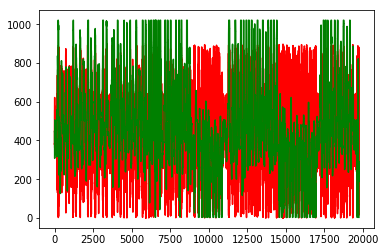

In [41]:
preds_converted = [int(p*128) for p in predictions]
labels = [ele[1] for ele in all_data_sequential]
x_ax = range(len(preds_converted))
print(np.shape(labels[:-46]))
print(np.shape(preds_converted))
plt.plot(x_ax, preds_converted, "r", x_ax, labels[:-46], "g")

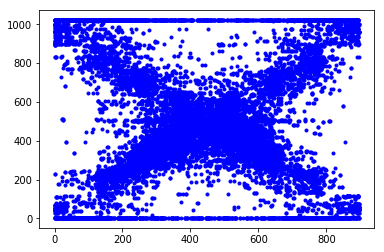

In [42]:
plt.plot(preds_converted, labels[:-46], 'b.')

In [ ]:
#print(all_img_paths[0].split('/')[-1].split('.')[0])
for a, img_pth in zip(angles, all_img_paths):
    im = img_pth.split('/')[-1].split('.')[0]
    with open("./to_make_movie.txt", 'a') as file:
        file.write("{}, {}\n".format(im, a[0:0]))

In [ ]:
from annotate_video_inplace import *
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./ep_19-step_50-loss_0.5418351888656616.ckpt')
    
    video_inference(sess, x, prediction, training, "/home/jp/Documents/FYP/ml/data/videoplayback.mp4", "/home/jp/Desktop/video_infer")

In [ ]:
os.path.exists("/home/jp/Documents/FYP/ml/data/videoplayback.mp4")